### Description of notebook

In this notebook, a balanced random forest (BRF) is trained on the publicly available Kaggle - Credit Card Fraud Detection. The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Overview of the notebook:
1. Loading libraries
2. Loading and preparing dataset
3. Training Balanced Random Forest
4. Evaluating model predictions
5. Performing sensitivity testing

### 1. Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc

### 2. Loading and preparing dataset

In [2]:
# Load dataset
data = pd.read_csv('./data/creditcard.csv')

# Drop 'Time' feature as it's not useful for classification
data = data.drop(columns=['Time'])

# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [39]:
# Display imbalancedness of dataset
print(data['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


### 3. Training Balanced Random Forest

In [3]:
# Initialize the Balanced Random Forest classifier
clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(random_state=42)

In [41]:
# parameters of BRF model
clf.n_features_

/opt/homebrew/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:902: FutureWarning: `n_features_` was deprecated in scikit-learn 1.0. This attribute will not be accessible when the minimum supported version of scikit-learn is 1.2.
  warn(


29

### 4. Evaluating the model

In [4]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Predict probabilities
y_proba = clf.predict_proba(X_test)[:, 1]

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Geometric Mean Score (G-mean)
gmean = geometric_mean_score(y_test, y_pred, average='macro')
print(f"Geometric Mean Score (G-mean): {gmean:.2f}")

Confusion Matrix:
[[82997  2310]
 [    9   127]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85307
           1       0.05      0.93      0.10       136

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.54     85443
weighted avg       1.00      0.97      0.98     85443

Geometric Mean Score (G-mean): 0.95


#### Plot precision-recall

Precision from Confusion Matrix for threshold 0.53: 0.06
Recall from Confusion Matrix for threshold 0.53: 0.93


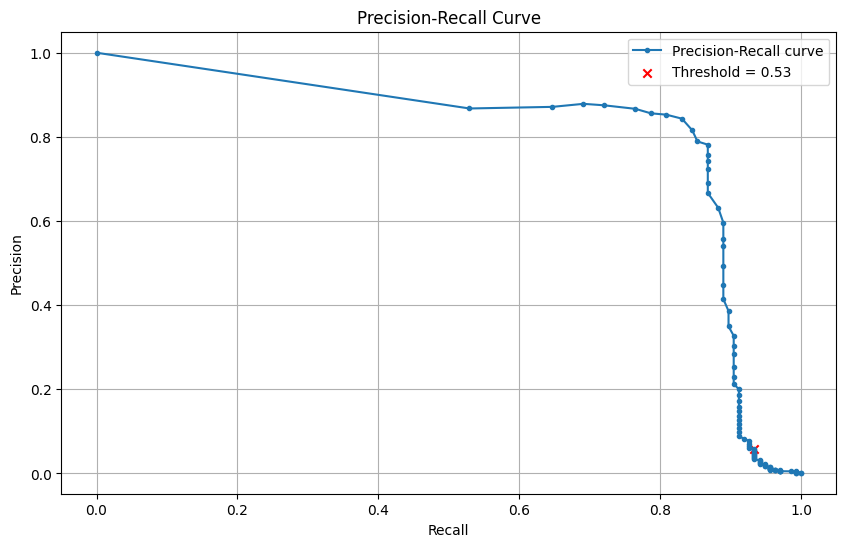

In [42]:
# Predict classes based on the threshold of interest
thres = 0.53
y_pred = (y_proba >= thres).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, FN, TN from confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calculate precision and recall based on confusion matrix
precision_from_cm = TP / (TP + FP)
recall_from_cm = TP / (TP + FN)
TPR_from_cm = TP / (TP + FN)
FPR_from_cm = FP / (FP + TN)

print(f"Precision from Confusion Matrix for threshold {thres}: {precision_from_cm:.2f}")
print(f"Recall from Confusion Matrix for threshold {thres}: {recall_from_cm:.2f}")

# Plot PR curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')

# Plot point from confusion matrix
plt.scatter(recall_from_cm, precision_from_cm, color='red', marker='x', label=f'Threshold = {thres}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

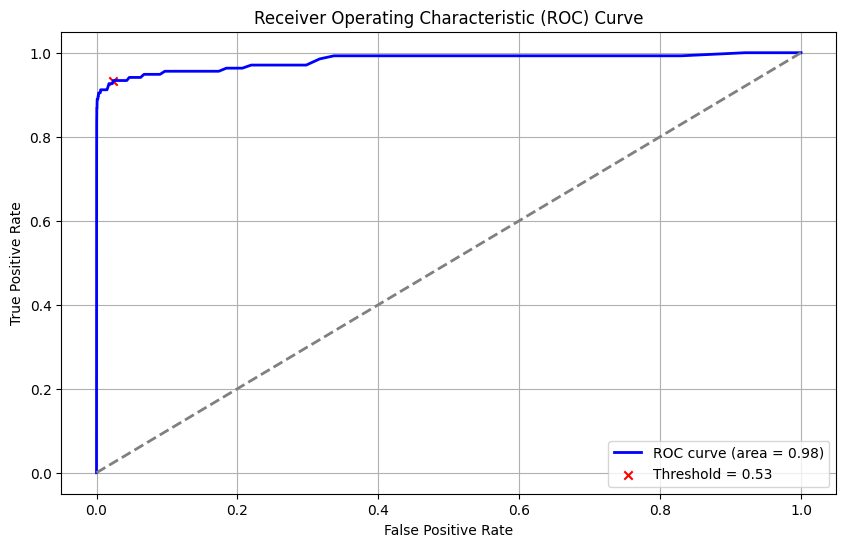

In [43]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Plot point from confusion matrix
plt.scatter(FPR_from_cm, TPR_from_cm, color='red', marker='x', label=f'Threshold = {thres}')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 5. Performing sensitivity testing

In [28]:
# Find the optimal threshold to balance false positives and false negatives
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Predict with the new threshold
y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

# Evaluate with the new threshold
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
print("Confusion Matrix with Adjusted Threshold:")
print(conf_matrix_adjusted)

# Classification report with the new threshold
class_report_adjusted = classification_report(y_test, y_pred_adjusted)
print("Classification Report with Adjusted Threshold:")
print(class_report_adjusted)

Optimal Threshold: 0.53
Confusion Matrix with Adjusted Threshold:
[[83259  2048]
 [    9   127]]
Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85307
           1       0.06      0.93      0.11       136

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.98      0.99     85443

